# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [17]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/NotAveragePooled/split_features_6s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [18]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [19]:
train_data

{'melspectrogram': array([[[2.70414866e-03, 2.79165306e-04, 2.78151976e-06, ...,
          2.09090982e-14, 1.00035500e-07, 4.10201886e-06],
         [2.85087147e-03, 2.95306839e-04, 3.42857310e-06, ...,
          2.42591675e-14, 1.00793242e-07, 4.13385302e-06],
         [3.04498922e-03, 3.15533762e-04, 4.71718391e-06, ...,
          3.06456201e-14, 1.02097112e-07, 4.18868937e-06],
         ...,
         [4.71950382e-06, 6.96979924e-07, 9.83989841e-06, ...,
          4.76671411e-08, 2.59462464e-08, 1.32848568e-07],
         [4.43196142e-06, 4.70733005e-07, 1.06044568e-07, ...,
          2.24950763e-10, 2.39690650e-09, 9.34205219e-08],
         [4.34125244e-06, 4.54310514e-07, 3.83112779e-09, ...,
          6.16144049e-13, 1.95562647e-09, 8.06973052e-08]],
 
        [[1.73426295e-05, 3.63408438e-06, 4.80290598e-13, ...,
          1.60876280e-14, 7.00188949e-08, 1.07775013e-06],
         [1.84753151e-05, 3.87795431e-06, 5.39064175e-13, ...,
          2.48021127e-14, 7.05198033e-08, 1.0866

In [20]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [21]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [22]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [23]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [24]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [25]:
display(train_y.shape)
display(train_y[:15])

(7105,)

array([ 1, 12, 12, 18,  0,  6,  9,  2, 15,  9, 15,  0,  9,  2, 12],
      dtype=int32)

In [26]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(7105, 60, 259)

array([[2.69040937e-03, 4.08457172e-04, 3.47520585e-13, ...,
        1.70315054e-13, 7.40936271e-06, 1.18791981e-04],
       [2.70075129e-03, 4.10013696e-04, 3.93403282e-13, ...,
        1.76836050e-13, 7.51821703e-06, 1.20539639e-04],
       [2.71822099e-03, 4.12641652e-04, 4.86951418e-13, ...,
        1.91108949e-13, 7.70506226e-06, 1.23548468e-04],
       ...,
       [2.08812007e-04, 3.18310420e-05, 4.35271934e-08, ...,
        4.00302065e-08, 1.74103692e-06, 2.63066062e-05],
       [1.88873108e-04, 2.87703725e-05, 1.76288301e-10, ...,
        1.57014632e-10, 1.42424630e-06, 2.29200435e-05],
       [1.77336857e-04, 2.70143104e-05, 2.32370972e-13, ...,
        1.17086386e-13, 1.32333290e-06, 2.13012012e-05]])

'mfcc'

(7105, 20, 259)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-2.66833218e-02, -8.44386385e-02, -2.18780501e-01, ...,
        -6.85011445e-02, -5.67708521e-02,  1.32065707e-03],
       [-2.91523600e-01, -3.71518719e-01, -5.11909230e-01, ...,
        -6.42755853e-01, -5.61886063e-01, -4.66257251e-01],
       ...,
       [ 2.05853752e-02,  1.67764035e-02,  1.82604346e-02, ...,
        -5.45051343e-03, -4.40125203e-03, -6.20501577e-03],
       [-2.02441326e-02, -1.86922074e-02,  6.89506115e-03, ...,
         2.59946840e-02,  3.16372681e-02,  1.47772717e-02],
       [-3.40333244e-02, -2.42458013e-02, -2.85292872e-02, ...,
        -2.39440187e-02, -8.50610909e-03, -4.04492834e-05]])

'chroma'

(7105, 12, 259)

array([[0.24864305, 0.29631535, 0.31045966, ..., 0.40069001, 0.50801101,
        0.38144471],
       [0.24534524, 0.28840458, 0.33379185, ..., 0.42041354, 0.50586702,
        0.62016281],
       [0.15298406, 0.11485447, 0.08231069, ..., 0.53125893, 0.64276512,
        0.46286747],
       ...,
       [1.        , 0.63096119, 0.77352367, ..., 0.64788047, 0.5271435 ,
        0.41385586],
       [0.97426447, 1.        , 1.        , ..., 0.45275858, 0.49202924,
        0.42027346],
       [0.27945555, 0.30617621, 0.26337507, ..., 0.58270217, 1.        ,
        0.5825718 ]])

'rms'

(7105, 1, 259)

array([[0.01612907, 0.02036163, 0.02236381, 0.02032115, 0.01881817,
        0.01514378, 0.01315711, 0.01117222, 0.01068601, 0.01038471,
        0.01493485, 0.02178646, 0.02435838, 0.02619782, 0.02583299,
        0.02277914, 0.02014609, 0.01751793, 0.01387478, 0.00852018,
        0.00690586, 0.00614171, 0.00770546, 0.01995697, 0.03698479,
        0.0426441 , 0.04647807, 0.04581114, 0.03440014, 0.02740226,
        0.01983235, 0.01073553, 0.0076463 , 0.00661767, 0.00606081,
        0.00634777, 0.00919547, 0.01277758, 0.01689507, 0.02074126,
        0.0227426 , 0.02257645, 0.02067827, 0.01722183, 0.01285113,
        0.00976115, 0.00711595, 0.00767853, 0.00995252, 0.01214419,
        0.01481564, 0.01701612, 0.01691237, 0.01644171, 0.01501546,
        0.01161532, 0.01009744, 0.00841241, 0.00682253, 0.00637262,
        0.00604512, 0.00532832, 0.00585929, 0.01020321, 0.01224944,
        0.01383804, 0.01583311, 0.01574408, 0.01638243, 0.01634659,
        0.01471977, 0.01260509, 0.00995492, 0.00

In [27]:
display(val_y.shape)
display(val_y[:15])

(1896,)

array([15,  2,  2,  2,  0, 18,  2,  7, 17,  3,  2, 19,  2, 19,  0],
      dtype=int32)

In [28]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(1896, 60, 259)

array([[1.93338063e-03, 1.98195157e-04, 1.73273927e-13, ...,
        2.43286351e-17, 1.53878134e-09, 4.13960773e-06],
       [1.95305293e-03, 2.00203552e-04, 3.07182569e-13, ...,
        4.05249738e-17, 1.54097439e-09, 4.14508204e-06],
       [1.98668457e-03, 2.03637224e-04, 8.56416508e-13, ...,
        1.40852237e-16, 1.54199312e-09, 4.15323324e-06],
       ...,
       [2.94063560e-05, 3.43539450e-06, 4.52336753e-07, ...,
        3.50377592e-10, 1.49650976e-10, 1.99068144e-08],
       [1.87940410e-05, 1.92592488e-06, 1.87399595e-09, ...,
        1.62022206e-12, 2.91367028e-12, 4.34889919e-09],
       [1.43345861e-05, 1.46661767e-06, 1.48607980e-12, ...,
        8.18254333e-15, 3.89491302e-13, 1.03254425e-09]])

'mfcc'

(1896, 20, 259)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 9.36995931e-04, -4.10784141e-02, -5.48068865e-02, ...,
        -2.44547020e-01, -1.29941895e-01, -4.45570580e-02],
       [-1.49456694e-01, -2.01091688e-01, -2.17933822e-01, ...,
        -4.17183472e-01, -2.65456366e-01, -2.08882452e-01],
       ...,
       [ 1.66309234e-02,  4.72972314e-03, -6.60423514e-03, ...,
        -4.14363098e-02, -1.30265896e-03,  8.01214063e-03],
       [ 1.55733605e-03,  3.83092921e-04,  5.37597060e-03, ...,
         6.81524392e-02,  5.77210351e-02,  2.78220487e-02],
       [-2.15722977e-03,  3.68533067e-03,  2.46079266e-03, ...,
        -2.97104379e-02, -7.97652348e-02, -3.74181350e-02]])

'chroma'

(1896, 12, 259)

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.04429035e-02, 2.32952201e-04, 1.81646110e-02],
       [3.90740244e-01, 3.20093565e-01, 5.87131300e-01, ...,
        4.22160377e-02, 1.99507003e-03, 2.90285305e-02],
       [3.92294799e-01, 2.52268114e-01, 6.10323358e-01, ...,
        4.90544230e-01, 1.83283318e-01, 1.27773882e-01],
       ...,
       [3.36610441e-01, 1.41244550e-01, 2.44668984e-01, ...,
        2.91197295e-02, 3.15024306e-03, 2.36044398e-02],
       [2.41128538e-01, 1.86966151e-01, 2.51816555e-01, ...,
        3.96117972e-03, 1.00874285e-03, 2.12197038e-02],
       [4.52456962e-01, 4.53742162e-01, 4.17860162e-01, ...,
        2.42732364e-03, 3.09255736e-04, 1.59454829e-02]])

'rms'

(1896, 1, 259)

array([[0.00062057, 0.00081435, 0.00100355, 0.00101341, 0.0009582 ,
        0.0008615 , 0.0006986 , 0.00064286, 0.00066621, 0.00070287,
        0.00073753, 0.00074409, 0.00074991, 0.00075677, 0.00079612,
        0.02027168, 0.04253102, 0.04830509, 0.04830541, 0.04385286,
        0.02291447, 0.00078997, 0.00082059, 0.00097988, 0.00100605,
        0.00095852, 0.00085913, 0.00066692, 0.00063826, 0.00064309,
        0.0006566 , 0.01604473, 0.03785714, 0.0458034 , 0.04594636,
        0.04622704, 0.03680744, 0.02719475, 0.02695601, 0.02107304,
        0.00711193, 0.00102109, 0.00092804, 0.00080745, 0.00078223,
        0.00076144, 0.00072847, 0.00064887, 0.00061626, 0.00061098,
        0.00062443, 0.00063061, 0.00062421, 0.00063657, 0.00068225,
        0.0006858 , 0.00067399, 0.0006922 , 0.00067687, 0.00642227,
        0.01179406, 0.01477852, 0.0150725 , 0.01366344, 0.00945538,
        0.01229848, 0.02199678, 0.0236273 , 0.02367615, 0.04526687,
        0.06944718, 0.07077155, 0.07075211, 0.05

## **CNN Model**

In [57]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add first convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=32,
              kernel_size=3,
              strides=1,
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)

  # add first max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

  # add second convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=64,
              kernel_size=3,
              strides=1,
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

  # add second max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.2)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [48]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [58]:
train_results = {}
val_results = {}

### **With all the features**

In [59]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(7105, 93, 259)

In [60]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(1896, 93, 259)

Fit the model with training data

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 93, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 93, 32)              │          24,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 795,540 (3.03 MB)

 Trainable params: 795,540 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.1618 - loss: 4.6579 - weighted_accuracy: 0.1618 - val_accuracy: 0.2954 - val_loss: 4.0161 - val_weighted_accuracy: 0.2954
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3183 - loss: 3.9225 - weighted_accuracy: 0.3183 - val_accuracy: 0.3064 - val_loss: 3.7488 - val_weighted_accuracy: 0.3064
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3973 - loss: 3.4838 - weighted_accuracy: 0.3973 - val_accuracy: 0.2811 - val_loss: 3.6078 - val_weighted_accuracy: 0.2811
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4417 - loss: 3.1974 - weighted_accuracy: 0.4417 - val_accuracy: 0.3370 - val_loss: 3.3894 - val_weighted_accuracy: 0.3370
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5007 - loss: 2.8998 - weighted_accuracy: 0.5007 - val_accuracy: 0.3223 - val_loss: 3.3362 - val_weighted_accuracy: 0.3223
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 41m

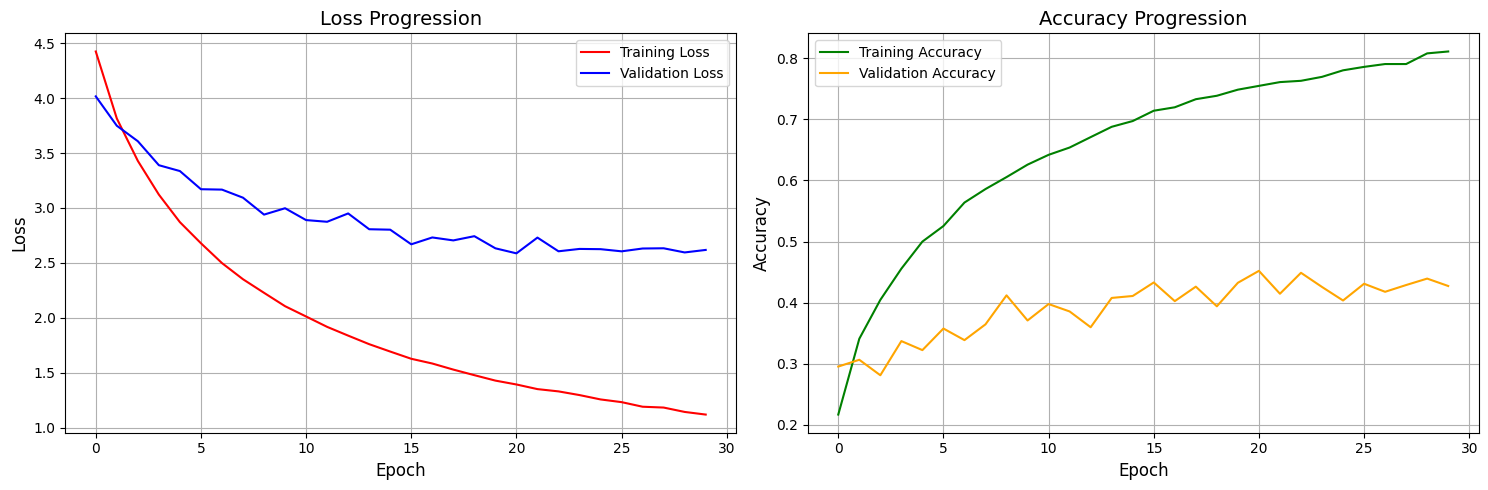

In [61]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [62]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7933 - loss: 1.3124 - weighted_accuracy: 0.7933
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4708 - loss: 2.4461 - weighted_accuracy: 0.4708


## **With MFCCs and Mel-Spectrogram**

In [63]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(7105, 80, 259)

In [64]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(1896, 80, 259)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 80, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 80, 32)              │          24,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,236 (2.66 MB)

 Trainable params: 697,236 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.1755 - loss: 4.6720 - weighted_accuracy: 0.1755 - val_accuracy: 0.2537 - val_loss: 4.0525 - val_weighted_accuracy: 0.2537
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3380 - loss: 3.8630 - weighted_accuracy: 0.3380 - val_accuracy: 0.2627 - val_loss: 3.8071 - val_weighted_accuracy: 0.2627
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4030 - loss: 3.4334 - weighted_accuracy: 0.4030 - val_accuracy: 0.3481 - val_loss: 3.4888 - val_weighted_accuracy: 0.3481
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4673 - loss: 3.0841 - weighted_accuracy: 0.4673 - val_accuracy: 0.3634 - val_loss: 3.3202 - val_weighted_accuracy: 0.3634
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5096 - loss: 2.8018 - weighted_accuracy: 0.5096 - val_accuracy: 0.3708 - val_loss: 3.2245 - val_weighted_accuracy: 0.3708
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/

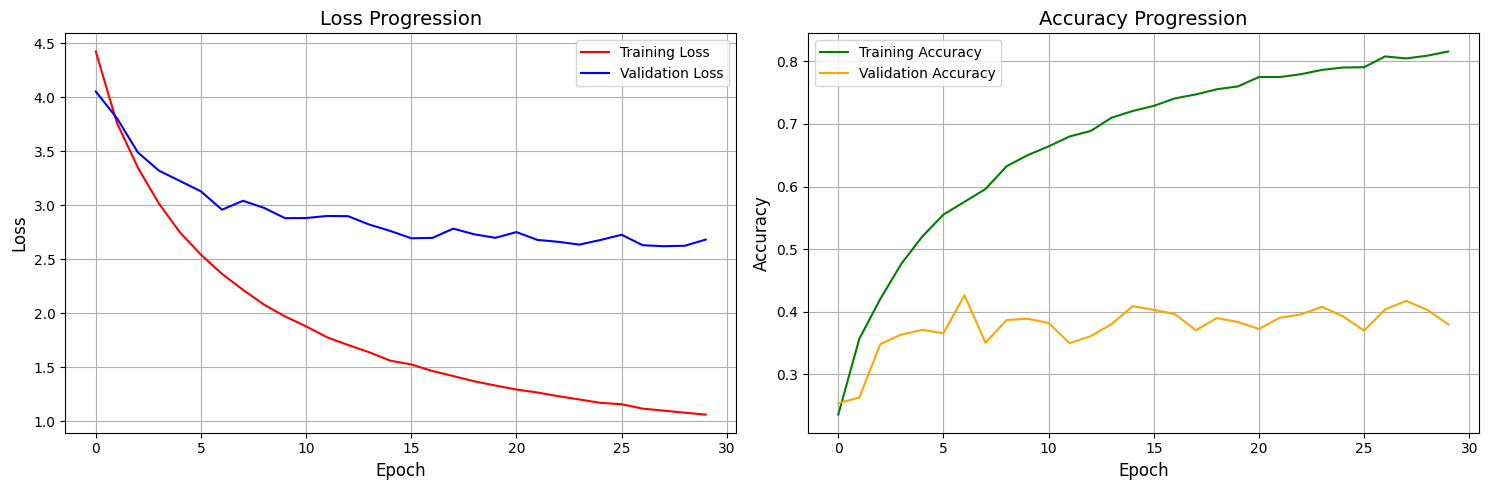

In [68]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [69]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8364 - loss: 1.0288 - weighted_accuracy: 0.8364
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4268 - loss: 2.4925 - weighted_accuracy: 0.4268


## **With Mel-Spectrogram, MFCCs, RMS**

In [70]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(7105, 81, 259)

In [71]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(1896, 81, 259)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 81, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 81, 32)              │          24,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,236 (2.66 MB)

 Trainable params: 697,236 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.1720 - loss: 4.6639 - weighted_accuracy: 0.1720 - val_accuracy: 0.2400 - val_loss: 4.0965 - val_weighted_accuracy: 0.2400
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.3145 - loss: 3.9055 - weighted_accuracy: 0.3145 - val_accuracy: 0.2484 - val_loss: 3.7901 - val_weighted_accuracy: 0.2484
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4045 - loss: 3.4584 - weighted_accuracy: 0.4045 - val_accuracy: 0.3344 - val_loss: 3.4908 - val_weighted_accuracy: 0.3344
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4606 - loss: 3.1178 - weighted_accuracy: 0.4606 - val_accuracy: 0.3070 - val_loss: 3.4655 - val_weighted_accuracy: 0.3070
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5169 - loss: 2.8324 - weighted_accuracy: 0.5169 - val_accuracy: 0.3629 - val_loss: 3.2552 - val_weighted_accuracy: 0.3629
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/

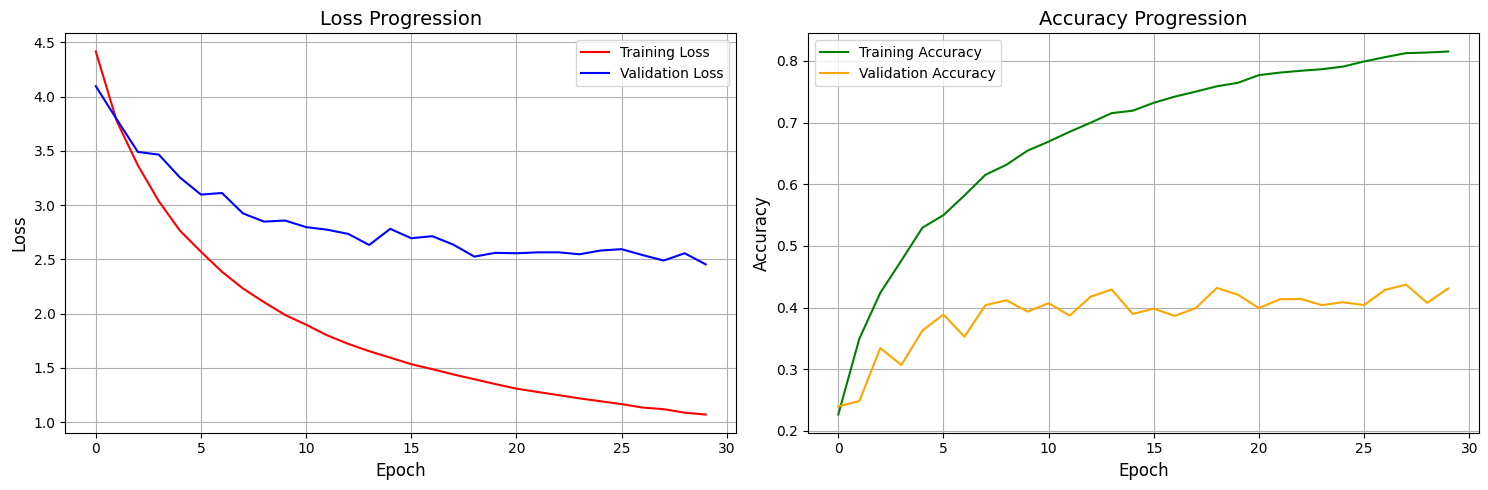

In [72]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [73]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8521 - loss: 0.9940 - weighted_accuracy: 0.8521
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4404 - loss: 2.3530 - weighted_accuracy: 0.4404


## **With Mel-Spectrogram, MFCCs, Chroma**

In [74]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(7105, 92, 259)

In [75]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(1896, 92, 259)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 92, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 92, 32)              │          24,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 795,540 (3.03 MB)

 Trainable params: 795,540 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1737 - loss: 4.6793 - weighted_accuracy: 0.1737 - val_accuracy: 0.3281 - val_loss: 4.0105 - val_weighted_accuracy: 0.3281
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3257 - loss: 3.9336 - weighted_accuracy: 0.3257 - val_accuracy: 0.3244 - val_loss: 3.7570 - val_weighted_accuracy: 0.3244
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.3826 - loss: 3.5458 - weighted_accuracy: 0.3826 - val_accuracy: 0.3497 - val_loss: 3.5300 - val_weighted_accuracy: 0.3497
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4290 - loss: 3.2400 - weighted_accuracy: 0.4290 - val_accuracy: 0.3771 - val_loss: 3.3123 - val_weighted_accuracy: 0.3771
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4762 - loss: 2.9540 - weighted_accuracy: 0.4762 - val_accuracy: 0.3914 - val_loss: 3.1327 - val_weighted_accuracy: 0.3914
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms

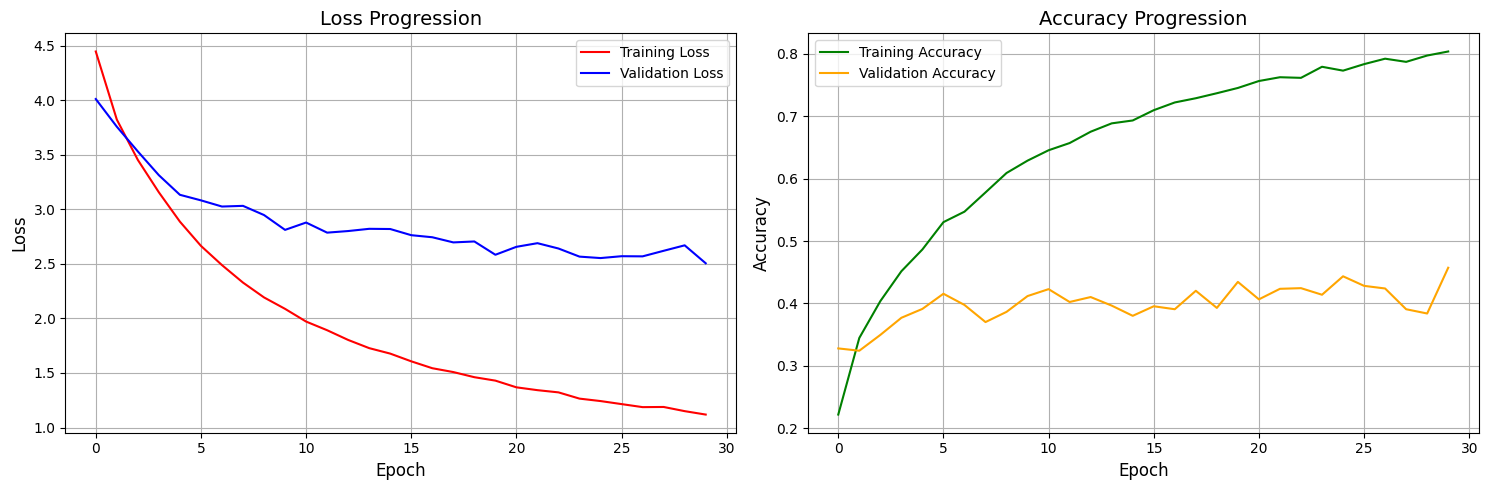

In [76]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [77]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8305 - loss: 1.0572 - weighted_accuracy: 0.8305
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4773 - loss: 2.3661 - weighted_accuracy: 0.4773


# Review results from all models

In [78]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.79,0.45
3,melspectrogram_chroma_mfcc,0.83,0.46
2,melspectrogram_rms_mfcc,0.85,0.43
1,mfcc_melspectrogram,0.84,0.42
